## Bijector Example
### from https://romainlhardy.medium.com/building-custom-bijectors-with-tensorflow-probability-22241cb6a691

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

In [1]:
base_distribution = tfd.MultivariateNormalDiag(loc=[0,0], scale_diag=[0.3,0.3])

theta_distribution = tfd.Uniform(low=0.0, high=2*math.pi)
alpha_distribution = tfd.Normal(loc=0.0, scale=3.0)

In [2]:
class Rotation2D(tfb.Bijector):
  def __init__(self, theta, validate_args=False, name="rotation_2d"):
    super(Rotation2D, self).__init__(
      validate_args=validate_args,
      forward_min_event_ndims=1,
      inverse_min_event_ndims=1,
      name=name,
      is_constant_jacobian=True
    )
    
    self.cos_theta = tf.math.cos(theta)
    self.sin_theta = tf.math.sin(theta)
    self.event_ndim = 1
  
  def _forward(self, x):
    batch_ndim = len(x.shape) - self.event_ndim
    x0 = tf.expand_dims(x[..., 0], batch_ndim)
    x1 = tf.expand_dims(x[..., 1], batch_ndim)
    y0 = self.cos_theta * x0 - self.sin_theta * x1
    y1 = self.sin_theta * x0 + self.cos_theta * x1
    return tf.concat((y0, y1), axis=-1)

  def _inverse(self, y):
    batch_ndim = len(y.shape) - self.event_ndim
    y0 = tf.expand_dims(y[..., 0], batch_ndim)
    y1 = tf.expand_dims(y[..., 1], batch_ndim)
    x0 = self.cos_theta * y0 + self.sin_theta * y1
    x1 = -self.sin_theta * y0 + self.cos_theta * y1
    return tf.concat((x0, x1), axis=-1)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

In [1]:
# Function to create a Rotation bijector using a LinearOperator bijector and a rotation matrix
def create_rotation_bijector(theta):
    cos_theta = tf.math.cos(theta)
    sin_theta = tf.math.sin(theta)
    rotation_matrix = [[cos_theta, -sin_theta], [sin_theta, cos_theta]]

    return tfb.ScaleMatvecLinearOperator(tf.linalg.LinearOperatorFullMatrix(rotation_matrix))

In [2]:
# Test the RotationBijector 
test_theta = theta_distribution.sample()

test_rotationBijector = create_rotation_bijector(test_theta)
test_x = tf.random.normal((2,))
print(test_theta)
print(test_x)
test_y = test_rotationBijector.forward(test_x)
print(test_y)
print(test_rotationBijector.inverse(test_y))

NameError: name 'theta_distribution' is not defined

In [5]:
# Define Bijector for f3(z) = (z1, z2 + alpha * z1 * z1)
class F3Bijector(tfb.Bijector):
  def __init__(self, alpha, validate_args=False, name="f3_bijector"):
    super(F3Bijector, self).__init__(
      validate_args=validate_args,
      forward_min_event_ndims=0,
      inverse_min_event_ndims=0,
      name=name,
      is_constant_jacobian=False
    )
    
    self.alpha = alpha
    self.event_ndim = 1
  
  def _forward(self, x):
    batch_ndim = len(x.shape) - self.event_ndim
    x1 = tf.expand_dims(x[..., 0], batch_ndim)
    x2 = tf.expand_dims(x[..., 1], batch_ndim)
    return tf.concat((x1, x2 + self.alpha * x1 * x1), axis=-1)

  def _inverse(self, y):
    batch_ndim = len(y.shape) - self.event_ndim
    y1 = tf.expand_dims(y[..., 0], batch_ndim)
    y2 = tf.expand_dims(y[..., 1], batch_ndim)
    return tf.concat((y1, y2 - self.alpha * y1 * y1), axis=-1)

  def _inverse_log_det_jacobian(self, y):
    # we evaluate det [[1.0, 0.0], [2 * alpha * y1, 1.0]] = 1
    # so log det is zero
    batch_ndim = len(y.shape) - self.event_ndim
    y1 = tf.expand_dims(y[..., 0], batch_ndim)
    return tf.zeros(shape=y1.shape)


In [6]:
# Test the F3Bijector 
test_alpha = alpha_distribution.sample()

test_f3Bijector = F3Bijector(test_alpha)

test_x = tf.random.normal((2,))
print(test_x)
test_y = test_f3Bijector.forward(test_x)
print(test_y) 
print(test_f3Bijector.inverse(test_y))
print(test_f3Bijector.inverse_log_det_jacobian(test_x, event_ndims=0))

tf.Tensor([0.8738146  0.37198964], shape=(2,), dtype=float32)
tf.Tensor([ 0.8738146 -4.539722 ], shape=(2,), dtype=float32)
tf.Tensor([0.8738146  0.37198964], shape=(2,), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)


In [7]:
def transform_distribution(alpha, theta):
    f3Bijector = F3Bijector(alpha)

    cos_theta = tf.math.cos(theta)
    sin_theta = tf.math.sin(theta)
    matrix = [[cos_theta, -sin_theta], [sin_theta, cos_theta]]

    rotationBijector = tfb.ScaleMatvecLinearOperator(tf.linalg.LinearOperatorFullMatrix(matrix))

    f1 = tfb.Shift([0., -2])
    f2 = tfb.Scale([1.0, 0.5])
    f3 = f3Bijector
    f4 = rotationBijector
    f5 = tfb.Tanh()

    bijectors = [f1, f2, f3, f4, f5]

    full_bijector = tfb.Chain(list(reversed(bijectors)))

    return tfd.TransformedDistribution(
        base_distribution,
        full_bijector
    )

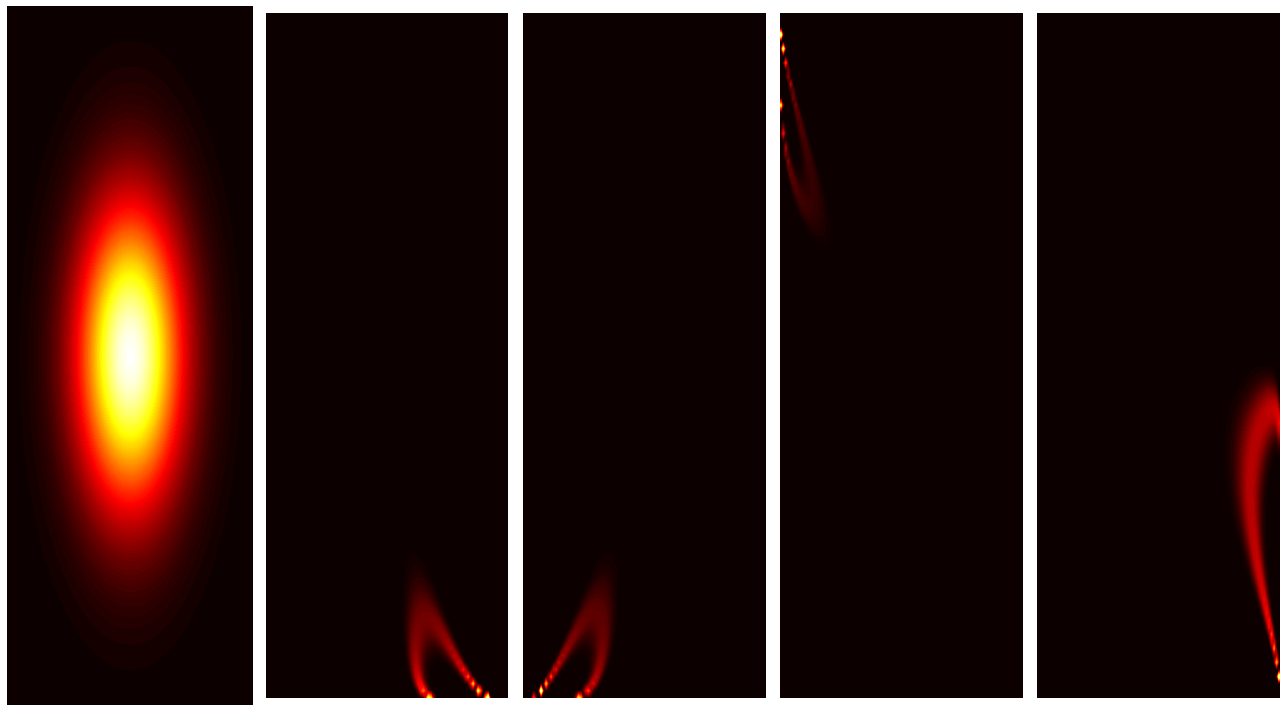

In [8]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [2, 1, 0])
Z_0 = base_distribution.prob(inputs).numpy()

fig, ax = plt.subplots(1, 5, figsize=(18, 10))
ax[0].contourf(X, Y, Z_0, cmap="hot", levels=100)
ax[0].axis("off")

for i in range(4):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(alpha, theta)
    
    Z_n = transformed_distribution.prob(inputs).numpy()
    ax[i+1].contourf(X, Y, Z_n, cmap="hot", levels=100)
    ax[i+1].axis("off")
    
plt.tight_layout()
plt.show()